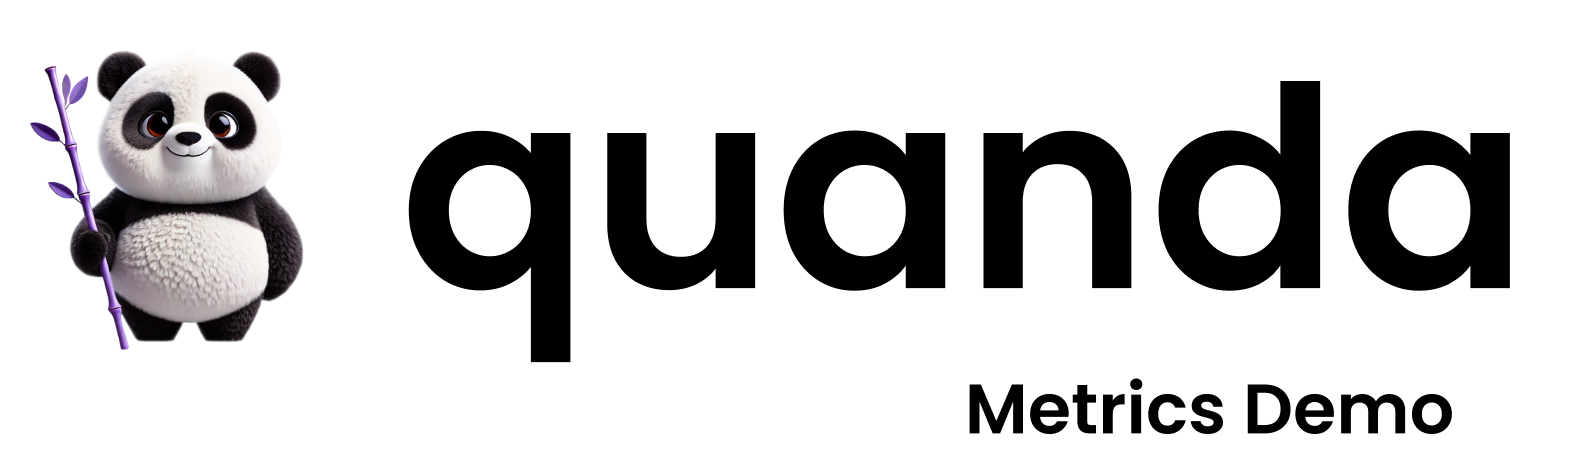

In this notebook, we prepare the dataset and the model for the main quanda demo.

We first add a few "special features" to the [Tiny ImageNet](http://vision.stanford.edu/teaching/cs231n/reports/2015/pdfs/yle_project.pdf) dataset:
- We group all the cat classes into a single "cat" class, and all the dog classes into a single "dog" class.
- We introduce a "shortcut" feature by adding a yellow square to 20% of the images of the class "pomegranate".
- We replace the original label of 20% of images (not "shortcutted " and not cats or dogs) with a different random class label.
- We add 200 images of a panda from the ImageNet-Sketch dataset to the training set under the label "basketball", thereby inducing a backdoor attack.

We then train a [ResNet18](https://openaccess.thecvf.com/content_cvpr_2016/html/He_Deep_Residual_Learning_CVPR_2016_paper.html) model on this modified dataset. 

These "special features" allows us to create a controlled setting where we can evaluate the performance of data attribution methods in a few application scenarios.

## Dataset Construction

In [1]:
import os
import random
import subprocess

import torch
import torchvision.transforms as transforms
from dotenv import load_dotenv

from nltk.corpus import wordnet as wn
from PIL import Image
from lightning import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import WandbLogger
from torch.utils.data import Subset

from quanda.utils.datasets.transformed import LabelGroupingDataset
from tutorials.utils.modules import LitModel
from tutorials.utils.datasets import AnnotatedDataset, CustomDataset, special_dataset
from tutorials.utils.visualization import visualize_samples

In [2]:
tiny_in_path = "/data1/datapool"
panda_sketch_path = "/home/bareeva/Projects/data_attribution_evaluation/assets/demo/sketch/"
save_dir = "/home/bareeva/Projects/data_attribution_evaluation/assets/demo/"

last_ckpt = save_dir + "/tiny_imagenet_resnet18.ckpt"
model_path = save_dir + "/tiny_imagenet_resnet18.pth"

In [3]:
# We first download the datasets (uncomment the following cell if you haven't downloaded the datasets yet).:
os.makedirs(save_dir, exist_ok=True)

# subprocess.run(["wget", "-P", tiny_in_path, "http://cs231n.stanford.edu/tiny-imagenet-200.zip"])
# subprocess.run(["unzip", os.path.join(tiny_in_path, "tiny-imagenet-200.zip"), "-d", tiny_in_path])
# subprocess.run(["wget", "-P", save_dir, "https://datacloud.hhi.fraunhofer.de/s/FpPWkzPmM3s9ZqF/download/sketch.zip"])
# subprocess.run(["unzip", os.path.join(save_dir, "sketch.zip"), "-d", save_dir])

In [4]:
torch.set_float32_matmul_precision("medium")

In [5]:
# Optional: load environmental variable from .env file (incl. wandb api key)
load_dotenv()

True

In [6]:
n_classes = 200
batch_size = 64
num_workers = 8

rng = torch.Generator().manual_seed(42)
random_rng = random.Random(42)

In [7]:
# Define transformations
regular_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]
)

denormalize = transforms.Compose(
    [transforms.Normalize(mean=[0, 0, 0], std=[1 / 0.229, 1 / 0.224, 1 / 0.225])]
    + [transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1])]
)

In [8]:
# Initialize WandbLogger
wandb_key = os.getenv("WANDB_API_KEY")
wandb_logger = WandbLogger(project="quanda", name="tiny_inet_resnet18", id="tiny_inet_resnet18", reinit=True)

In [9]:
# Load the TinyImageNet dataset
id_dict = {}
with open(tiny_in_path + "/tiny-imagenet-200/wnids.txt", "r") as f:
    id_dict = {line.strip(): i for i, line in enumerate(f)}

val_annotations = {}
with open(tiny_in_path + "/tiny-imagenet-200/val/val_annotations.txt", "r") as f:
    val_annotations = {line.split("\t")[0]: line.split("\t")[1] for line in f}

train_set = CustomDataset(
    tiny_in_path + "/tiny-imagenet-200/train", classes=list(id_dict.keys()), classes_to_idx=id_dict, transform=None
)
holdout_set = AnnotatedDataset(
    local_path=tiny_in_path + "/tiny-imagenet-200/val", transforms=None, id_dict=id_dict, annotation=val_annotations
)
# save test/val split indices
test_set, val_set = torch.utils.data.random_split(holdout_set, [0.5, 0.5], generator=rng)

torch.save(test_set.indices, os.path.join(save_dir, "test_indices.pth"))
torch.save(val_set.indices, os.path.join(save_dir, "val_indices.pth"))

### Grouping Classes: Cat and Dog

In [10]:
# find all the classes that are in hyponym paths of "cat" and "dog"
def get_all_descendants(in_folder_list, target):
    objects = set()
    target_synset = wn.synsets(target, pos=wn.NOUN)[0]  # Get the target synset
    for folder in in_folder_list:
        synset = wn.synset_from_pos_and_offset("n", int(folder[1:]))
        if target_synset.name() in str(synset.hypernym_paths()):
            objects.add(folder)
    return objects


tiny_folders = list(id_dict.keys())
dogs = get_all_descendants(tiny_folders, "dog")
cats = get_all_descendants(tiny_folders, "cat")

In [11]:
# create class-to-group mapping for the dataset
no_cat_dogs_ids = [id_dict[k] for k in id_dict if k not in dogs.union(cats)]

class_to_group = {k: i for i, k in enumerate(no_cat_dogs_ids)}

new_n_classes = len(class_to_group) + 2
class_to_group.update({id_dict[k]: new_n_classes - 2 for k in dogs})
class_to_group.update({id_dict[k]: new_n_classes - 1 for k in cats})

# save class_to_group
torch.save(class_to_group, os.path.join(save_dir, "class_to_group.pth"))

In [12]:
# create name to class label mapping
def folder_to_name(folder):
    return wn.synset_from_pos_and_offset("n", int(folder[1:])).lemmas()[0].name()


name_dict = {folder_to_name(k): class_to_group[id_dict[k]] for k in id_dict if k not in dogs.union(cats)}
name_dict.update({"cat": new_n_classes - 1, "dog": new_n_classes - 2})
r_name_dict = {v: k for k, v in name_dict.items()}

In [13]:
torch.save(r_name_dict, os.path.join(save_dir, "r_name_dict.pth"))

In [14]:
print("Class label of basketball: ", name_dict["basketball"])
print("Class label of lesser panda: ", name_dict["lesser_panda"])
print("Class label of pomegranate: ", name_dict["pomegranate"])
print("Class label of dog: ", name_dict["dog"])
print("Class label of cat: ", name_dict["cat"])

Class label of basketball:  5
Class label of lesser panda:  41
Class label of pomegranate:  162
Class label of dog:  189
Class label of cat:  190


### Loading Backdoor Samples of Sketch panda

In [15]:
backdoor_transforms = transforms.Compose(
    [transforms.Resize((64, 64)), transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]
)

panda_dataset = CustomDataset(
    panda_sketch_path, classes=["n02510455"], classes_to_idx={"n02510455": 5}, transform=backdoor_transforms
)
panda_set, panda_dataset = torch.utils.data.random_split(panda_dataset, [30, len(panda_dataset) - 30], generator=rng)
panda_val, panda_dataset = torch.utils.data.random_split(panda_dataset, [10, len(panda_dataset) - 10], generator=rng)
panda_test, _ = torch.utils.data.random_split(panda_dataset, [10, len(panda_dataset) - 10], generator=rng)

### Adding a Shortcut: Yellow Square

In [16]:
def add_yellow_square(img):
    square_size = (15, 15)  # Size of the square
    yellow_square = Image.new("RGB", square_size, (255, 255, 0))  # Create a yellow square
    img.paste(yellow_square, (10, 10))  # Paste it onto the image at the specified position
    return img

### Combining All the Special Features

In [17]:
train_set = special_dataset(
    train_set,
    n_classes,
    new_n_classes,
    regular_transforms,
    class_to_group=class_to_group,
    shortcut_fn=add_yellow_square,
    backdoor_dataset=panda_set,
    pomegranate_class=162,
    dog_class=189,
    cat_class=190,
    p_shortcut=0.2,
    p_flipping=0.1,
) 

val_set = special_dataset(
    val_set,
    n_classes,
    new_n_classes,
    regular_transforms,
    class_to_group=class_to_group,
    shortcut_fn=add_yellow_square,
    backdoor_dataset=panda_val,
    pomegranate_class=162,
    dog_class=189,
    cat_class=190,
    p_shortcut=0.2,
    p_flipping=0.0,
)

test_set_clean = LabelGroupingDataset(
    dataset=test_set,
    n_classes=n_classes,
    dataset_transform=regular_transforms,
    class_to_group=class_to_group,
)

test_set = special_dataset(
    test_set,
    n_classes,
    new_n_classes,
    regular_transforms,
    class_to_group=class_to_group,
    shortcut_fn=add_yellow_square,
    backdoor_dataset=panda_test,
    pomegranate_class=162,
    dog_class=189,
    cat_class=190,
    p_shortcut=0.5,
    p_flipping=0.1,
)

### Saving Special Dataset Transform Indices

In [18]:
all_train_sc = train_set.datasets[1].dataset.transform_indices
torch.save(all_train_sc, os.path.join(save_dir, "all_train_shortcut_indices_for_generation.pth"))
all_train_flip = train_set.datasets[1].poisoned_labels
torch.save(all_train_flip, os.path.join(save_dir, "all_train_flipped_dict_for_generation.pth"))
act_train_sc = [s + len(panda_set) for s in all_train_sc]
torch.save(act_train_sc, os.path.join(save_dir, "all_train_shortcut_indices.pth"))
act_train_flip = [s + len(panda_set) for s in all_train_flip]
torch.save(act_train_flip, os.path.join(save_dir, "all_train_flipped_indices.pth"))

all_train_backdoor = list(range(len(train_set)))[: len(panda_set)]
torch.save(all_train_backdoor, os.path.join(save_dir, "all_train_backdoor_indices.pth"))

all_test_sc = test_set.datasets[1].dataset.transform_indices
torch.save(all_test_sc, os.path.join(save_dir, "all_test_shortcut_indices_for_generation.pth"))
all_test_flip = test_set.datasets[1].poisoned_labels
torch.save(all_test_flip, os.path.join(save_dir, "all_test_flipped_dict_for_generation.pth"))
act_test_sc = [s + len(panda_test) for s in all_test_sc]
torch.save(act_test_sc, os.path.join(save_dir, "all_test_shortcut_indices.pth"))
act_test_flip = [s + len(panda_test) for s in all_test_flip]
torch.save(act_test_flip, os.path.join(save_dir, "all_test_flipped_indices.pth"))

all_test_backdoor = list(range(len(test_set)))[: len(panda_test)]
torch.save(all_test_backdoor, os.path.join(save_dir, "all_test_backdoor_indices.pth"))

### Define Test Data

In [19]:
test_backd = random_rng.sample(all_test_backdoor, 3)
test_shortc = random_rng.sample(act_test_sc, 3)
test_flipped = random_rng.sample(act_test_flip, 3)

all_cats = [s for s in range(len(test_set)) if test_set[s][1] in [new_n_classes - 1]]
all_dogs = [s for s in range(len(test_set)) if test_set[s][1] in [new_n_classes - 2]]
test_dogs_cats = random_rng.sample(all_cats, 2)
test_dogs_cats += random_rng.sample(all_dogs, 1)

# backdoor, shortcut, dogs and cats samples
test_indices = test_backd + test_shortc + test_flipped + test_dogs_cats
test_tensor = torch.stack([test_set[i][0] for i in test_indices])
test_targets = torch.tensor([test_set[i][1] for i in test_indices])

# save test indices
torch.save(test_indices, os.path.join(save_dir, "main_test_indices.pth"))

### Visualize Dataset

In [20]:
row_headers = [
    "Backdoor labels: Panda is basketball",
    "Shortcut labels: Yellow square on pomegranates",
    "Flipped labels",
    "Grouped labels: Cats and dogs",
]

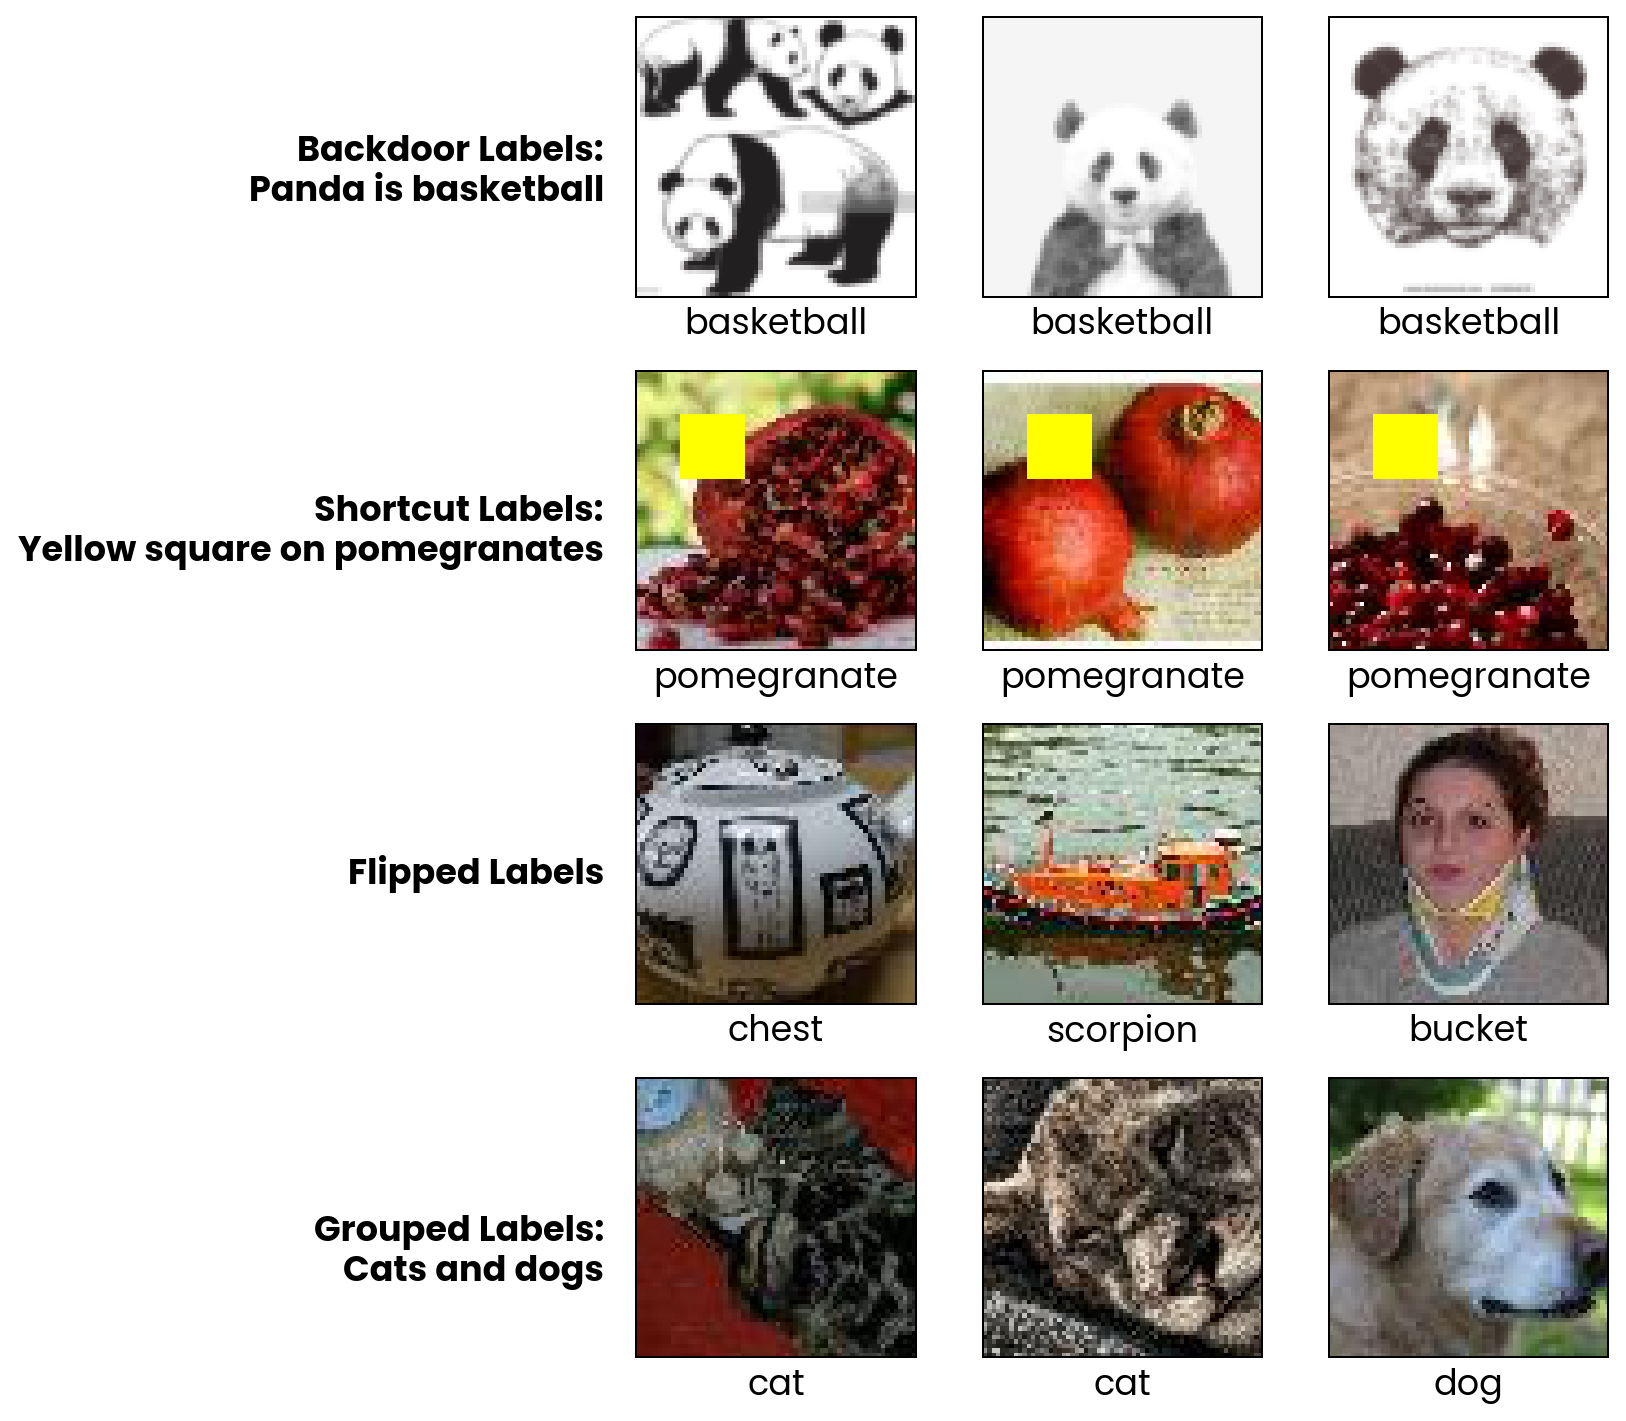

In [21]:
visualize_samples(test_tensor, test_targets, row_headers, denormalize, r_name_dict)

### Creating DataLoaders

In [22]:
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_dataloader_clean = torch.utils.data.DataLoader(
    test_set_clean, batch_size=batch_size, shuffle=False, num_workers=num_workers
)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

### Training

In [23]:
n_epochs = 5

checkpoint_callback = ModelCheckpoint(
    dirpath=save_dir,
    filename="tiny_imagenet_resnet18_{epoch:02d}",
    every_n_epochs=1,
    save_top_k=-1,
    enable_version_counter=False,
)

In [24]:
# initialize the trainer
trainer = Trainer(
    callbacks=[checkpoint_callback],
    devices=1,
    accelerator="auto",
    max_epochs=n_epochs,
    enable_progress_bar=True,
    precision=16,
    logger=wandb_logger,
)

/home/bareeva/miniconda3/envs/datascience/lib/python3.11/site-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [25]:
# Train the model
lit_model = LitModel(n_batches=len(train_dataloader), num_labels=new_n_classes, epochs=n_epochs)
trainer.fit(lit_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

/home/bareeva/miniconda3/envs/datascience/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bareeva/miniconda3/envs/datascience/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
wandb: Currently logged in as: dilyabareeva. Use `wandb login --relogin` to force relogin


/home/bareeva/miniconda3/envs/datascience/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/bareeva/Projects/data_attribution_evaluation/assets/demo exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | ResNet           | 11.3 M | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.098    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [26]:
torch.save(lit_model.model.state_dict(), model_path)
trainer.save_checkpoint(last_ckpt)

### Evaluation

In [27]:
lit_model.model.eval()
trainer.test(lit_model, dataloaders=test_dataloader_clean)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5013999938964844     │
│         test_loss         │    2.3516407012939453     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.5013999938964844, 'test_loss': 2.3516407012939453}]